<a href="https://colab.research.google.com/github/callalilyleaf/CSE-450-Machine-Learning/blob/main/predictions_Ivan_ult.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First prediction

In [75]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

from imblearn.over_sampling import RandomOverSampler


# Load data
url = "https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bank.csv"
df = pd.read_csv(url)
df["y"] = (df["y"] == "yes").astype(int)

# High-signal features
selected_features = [
    "campaign", "pdays", "previous", "poutcome",
    "contact", "month",
    "euribor3m", "nr.employed",
    "emp.var.rate", "cons.conf.idx"
]

X = pd.get_dummies(df[selected_features], drop_first=True)
y = df["y"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# Partial oversampling (NOT 1:1)
ros = RandomOverSampler(sampling_strategy=0.4, random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# Balanced model
rf = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    class_weight={0: 1, 1: 1.5},
    n_jobs=-1
)
rf.fit(X_train_ros, y_train_ros)

# Probabilities
probs = rf.predict_proba(X_test)[:, 1]

high_value = (
    (X_test["previous"] > 0) &
    (X_test["campaign"] <= 2) &
    (X_test["pdays"] < 900)
)

# Balanced thresholds
preds = np.zeros(len(probs), dtype=int)
preds[(probs >= 0.55) | ((probs >= 0.40) & high_value)] = 1

# Evaluation
cm = confusion_matrix(y_test, preds)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, preds))
print("Calls made:", preds.sum())


Confusion Matrix:
 [[7712  504]
 [ 587  465]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93      8216
           1       0.48      0.44      0.46      1052

    accuracy                           0.88      9268
   macro avg       0.70      0.69      0.70      9268
weighted avg       0.88      0.88      0.88      9268

Calls made: 969


Plots


In [76]:
# Reverting to the Stacked Layout (Bar + Line + Dotted Line)

# Plot A: Bar Chart for Counts
p_counts = (ggplot(monthly_stats, aes(x='month', y='count')) +
            geom_bar(stat='identity', fill='#b3cde3', tooltips=layer_tooltips().line('Count|@count')) +
            geom_text(aes(label='count'), vjust=-0.5, size=10) +
            ggtitle('1. Volume of Contacts') +
            theme(axis_title_x='blank'))

# Plot B: Probability of Yes (Solid Line)
p_prob = (ggplot(monthly_stats, aes(x='month', y='prob_yes')) +
          geom_line(color='#377eb8', size=1.2, linetype='solid') +
          geom_point(color='#377eb8', size=3) +
          geom_text(aes(label='prob_yes'), format='.2f', vjust=-1, color='#377eb8') +
          ggtitle('2. Probability of Subscription (Solid)') +
          ylab('Probability') +
          theme(axis_title_x='blank'))

# Plot C: Avg Consumer Confidence Index (Dotted/Dashed Line)
p_conf = (ggplot(monthly_stats, aes(x='month', y='avg_conf_idx')) +
          geom_line(color='#e41a1c', linetype='dashed', size=1.2) +
          geom_point(color='#e41a1c', size=3) +
          geom_text(aes(label='avg_conf_idx'), format='.1f', vjust=1.5, color='#e41a1c') +
          ggtitle('3. Avg Consumer Confidence Index (Dotted)') +
          ylab('Conf. Index') +
          xlab('Month'))

# Combine vertically
gggrid([p_counts, p_prob, p_conf], ncol=1)

In [77]:
# Combined Overlapping Chart in Lets-Plot
# Re-creating monthly_stats as requested

import pandas as pd
from lets_plot import *
LetsPlot.setup_html()

# 1. Prepare Data
month_order = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
df['month'] = pd.Categorical(df['month'], categories=month_order, ordered=True)

monthly_stats = df.groupby('month', observed=False).agg(
    count=('y', 'count'),
    prob_yes=('y', 'mean'),
    avg_conf_idx=('cons.conf.idx', 'mean')
).reset_index()

# 2. Scale Columns for Visualization (Fitting lines to Volume axis)
# Max Volume ~12,400
# Max Prob ~0.5 -> Scale factor 24,000
# Conf Index -50 to -30 -> Shift +50, Scale factor 600

monthly_stats['prob_scaled'] = monthly_stats['prob_yes'] * 24000
monthly_stats['conf_scaled'] = (monthly_stats['avg_conf_idx'] + 50) * 600

# 3. Plot
p_overlap = (ggplot(monthly_stats, aes(x='month')) +

    # Layer 1: Bar Chart (Volume)
    geom_bar(aes(y='count'), stat='identity', fill='#b3cde3',
             tooltips=layer_tooltips().line('Count|@count')) +
    geom_text(aes(y='count', label='count'), vjust=-0.5, color='#5c6f7e') +

    # Layer 2: Probability of Yes (Solid Blue Line)
    geom_line(aes(y='prob_scaled'), color='#377eb8', size=1.5, linetype='solid') +
    geom_point(aes(y='prob_scaled'), color='#377eb8', size=3,
               tooltips=layer_tooltips().line('Probability|@prob_yes')) +

    # Layer 3: Cons. Conf. Index (Dashed Red Line)
    geom_line(aes(y='conf_scaled'), color='#e41a1c', size=1.5, linetype='dashed') +
    geom_point(aes(y='conf_scaled'), color='#e41a1c', size=3,
               tooltips=layer_tooltips().line('Conf. Index|@avg_conf_idx')) +

    # Labels & Theme
    ggtitle('Sample Size vs. Confident Index & Accepting Probability') +
    ylab('Volume (Lines Scaled to fit)') +
    xlab('Month')
)

p_overlap

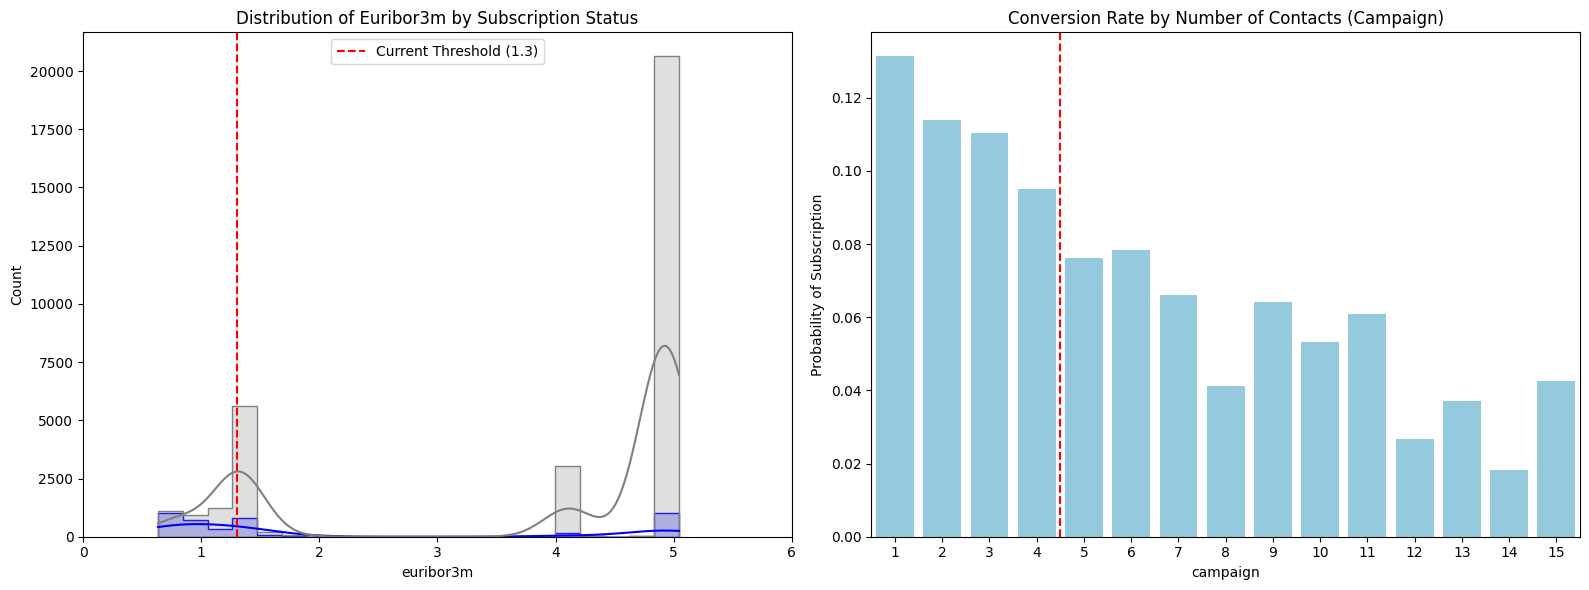

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Analyze Euribor3m Threshold
# We want to see where the density of Subscribers (1) is highest
sns.histplot(data=df, x='euribor3m', hue='y', kde=True, element='step', ax=axes[0], palette={0: 'gray', 1: 'blue'})
axes[0].set_title('Distribution of Euribor3m by Subscription Status')
axes[0].set_xlim(0, 6)
axes[0].axvline(x=1.3, color='red', linestyle='--', label='Current Threshold (1.3)')
axes[0].legend()

# 2. Analyze Campaign Threshold
# Calculate conversion rate per campaign number
campaign_stats = df.groupby('campaign')['y'].mean().reset_index()
campaign_stats = campaign_stats[campaign_stats['campaign'] <= 15] # Focus on first 15 calls

sns.barplot(data=campaign_stats, x='campaign', y='y', color='skyblue', ax=axes[1])
axes[1].set_title('Conversion Rate by Number of Contacts (Campaign)')
axes[1].axvline(x=3.5, color='red', linestyle='--', label='Current Threshold (4)')
axes[1].set_ylabel('Probability of Subscription')

plt.tight_layout()
plt.show()

Number of high_value cases: 93 out of 9268 (1.00%)


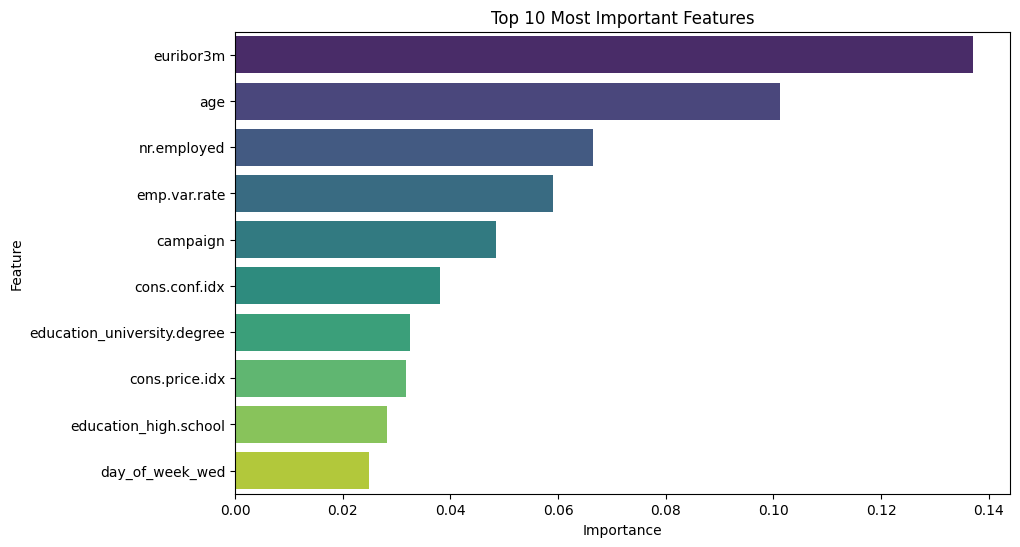

In [50]:
# 1. Check how many test samples qualify as 'high_value'
n_high_value = high_value.sum()
print(f"Number of high_value cases: {n_high_value} out of {len(X_test)} ({n_high_value/len(X_test):.2%})")

# 2. Check Feature Importances to see what actually drives predictions
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

importances = rf.feature_importances_
feature_names = X.columns
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
# Fix: Assign y to hue and set legend=False to avoid FutureWarning
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, hue='Feature', palette='viridis', legend=False)
plt.title('Top 10 Most Important Features')
plt.show()

In [69]:
# Plot of cons.conf.idx vs.

import pandas as pd
from lets_plot import *
LetsPlot.setup_html()

# 1. Prepare Data
# Ensure month order is preserved
month_order = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
df['month'] = pd.Categorical(df['month'], categories=month_order, ordered=True)

# Aggregate data: count, prob_yes, avg_conf_idx
monthly_stats = df.groupby('month', observed=False).agg(
    count=('y', 'count'),
    prob_yes=('y', 'mean'),
    avg_conf_idx=('cons.conf.idx', 'mean')
).reset_index()

# 2. Define Plots

# Plot A: Bar Chart for Counts
p_counts = (ggplot(monthly_stats, aes(x='month', y='count')) +
            geom_bar(stat='identity', fill='#b3cde3', tooltips=layer_tooltips().line('Count|@count')) +
            geom_text(aes(label='count'), vjust=-0.5, size=10) +
            ggtitle('1. Volume of Contacts per Month') +
            theme(axis_title_x='blank'))

# Plot B: Probability of Yes
p_prob = (ggplot(monthly_stats, aes(x='month', y='prob_yes')) +
          geom_line(color='#377eb8', size=1.2) +
          geom_point(color='#377eb8', size=3) +
          geom_text(aes(label='prob_yes'), format='.2f', vjust=-1, color='#377eb8') +
          ggtitle('2. Probability of Subscription (Yes)') +
          ylab('Probability') +
          theme(axis_title_x='blank'))

# Plot C: Avg Consumer Confidence Index
p_conf = (ggplot(monthly_stats, aes(x='month', y='avg_conf_idx')) +
          geom_line(color='#e41a1c', linetype='dashed', size=1.2) +
          geom_point(color='#e41a1c', size=3) +
          geom_text(aes(label='avg_conf_idx'), format='.1f', vjust=1.5, color='#e41a1c') +
          ggtitle('3. Avg Consumer Confidence Index') +
          ylab('Conf. Index') +
          xlab('Month'))

# 3. Combine Plots (Vertical Stack)
# We use gggrid to stack them
gggrid([p_counts, p_prob, p_conf], ncol=1)